<a href="https://colab.research.google.com/github/sandeepthetechie/mastering_the_art_of_tensorflow/blob/master/05_transfer_learning_with_TF_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-22 16:23:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-22 16:23:57 (69.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


# Let's get some data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-09-22 16:23:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   196MB/s    in 0.8s    

2021-09-22 16:24:00 (196 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [5]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
import tensorflow as tf 
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir, 
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir, 
                                                                image_size = IMG_SIZE, 
                                                                label_mode = "categorical",
                                                                batch_size = 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[121.57143    140.57143    183.57143   ]
   [119.28571    136.2857     180.2857    ]
   [115.78061    129.41327    174.41327   ]
   ...
   [188.64285     60.642857     0.        ]
   [189.31123     61.31123      0.        ]
   [189.77042     61.77042      0.        ]]

  [[133.66837    154.66837    201.52551   ]
   [131.85204    149.85204    197.70918   ]
   [131.18367    147.34184    194.02551   ]
   ...
   [190.78574     62.785736     0.        ]
   [191.92856     63.92856      0.92855835]
   [189.71425     61.71425      0.        ]]

  [[122.77551    144.70918    196.13266   ]
   [126.841835   147.14285    198.69897   ]
   [128.73979    146.14285    196.73979   ]
   ...
   [189.40308     62.045937     0.        ]
   [189.30101     61.943867     0.        ]
   [187.57143     60.214287     0.        ]]

  ...

  [[  9.653024    13.653024    24.867289  ]
   [  9.857164    13.857164    25.071428  ]
   [  8.42855     12.42855     23.5969    ]
   ...
   [ 58.785736    70.214

In [9]:

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False 

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important infromation, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210922-162407


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 18s 379ms/step - loss: 1.8690 - accuracy: 0.4133 - val_loss: 1.3222 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 7s 264ms/step - loss: 1.1201 - accuracy: 0.7707 - val_loss: 0.9186 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - 9s 355ms/step - loss: 0.8349 - accuracy: 0.8053 - val_loss: 0.7465 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 7s 264ms/step - loss: 0.6742 - accuracy: 0.8507 - val_loss: 0.6654 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 7s 265ms/step - loss: 0.5858 - accuracy: 0.8747 - val_loss: 0.5977 - val_accuracy: 0.8454


In [10]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

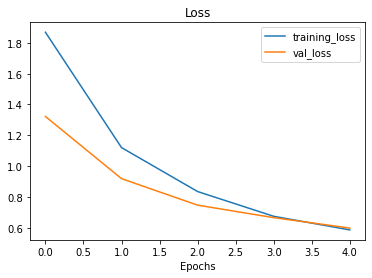

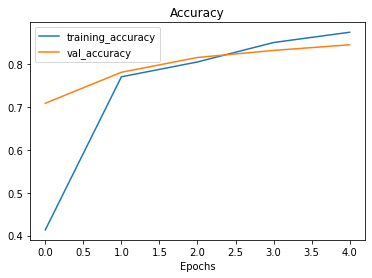

In [11]:
plot_loss_curves(history_10_percent)

# Getting a featured vector from trained model. 

In [12]:
# Define the input shape. 
input_shape = (1, 4, 4, 3)

# Create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: {input_tensor}")

Random input tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [13]:
# Pass the random tensor through a global average pooling 2D layer.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled tensor: {global_average_pooled_tensor}")

# Shape of the tensors. 
print(f"shape of the input tensor: {input_tensor.shape}")
print(f"shape of the global average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

2D global average pooled tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]
shape of the input tensor: (1, 4, 4, 3)
shape of the global average Pooled 2D tensor: (1, 3)


In [14]:
# Let's replicate the GlobalAveragePooling2D layer. 
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [15]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-09-22 16:24:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   164MB/s    in 0.8s    

2021-09-22 16:24:59 (164 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [16]:
# Creating training and testing dir 
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [17]:
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE, 
                                                                           batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE, 
                                                                           batch_size = 32)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding Data Augmentation right into the model 

In [18]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data segmentation stage with horizontal flipping, rotations, zooms, etc.

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = "data_augmentation")

(-0.5, 595.5, 600.5, -0.5)

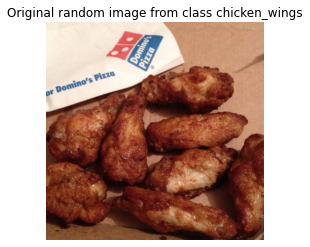

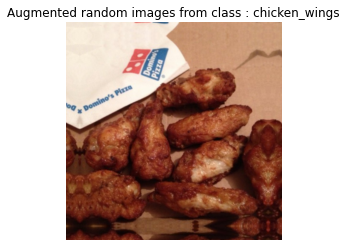

In [19]:
# Visualize our data augmentation layer. 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read the random image. 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class {target_class}')
plt.axis(False)

# Now lets plot augmented random image. 
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random images from class : {target_class}")
plt.axis(False)

In [20]:
# Setup input shape and base model, freezing the base model layers. 
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create input layer. 
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add data augmentation sequential layer as a layer.
x= data_augmentation(inputs)

# give base model the inputs(after augmentation) and don't train it. 
x = base_model(x, training = False)

# Pool output features of the base model. 
x = layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)

# Put a dense layer on as output. 
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

# Compile the model. 
model_1.compile(loss = "categorical_crossentropy", 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent, 
                                epochs = 5, 
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210922-162506
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 14s 3s/step - loss: 2.3902 - accuracy: 0.0857 - val_loss: 2.2142 - val_accuracy: 0.1809
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1372 - accuracy: 0.3143 - val_loss: 2.0998 - val_accuracy: 0.2648
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9454 - accuracy: 0.4429 - val_loss: 1.9862 - val_accuracy: 0.3372
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.7844 - accuracy: 0.6000 - val_loss: 1.9028 - val_accuracy: 0.3684
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6545 - accuracy: 0.5857 - val_loss: 1.8134 - val_accuracy: 0.4359


In [21]:
# Evaluate on the full test Dataset. 
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 136ms/step - loss: 1.8203 - accuracy: 0.4356


[1.820296049118042, 0.43560001254081726]

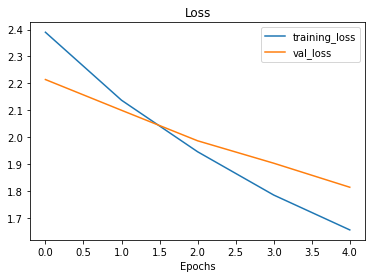

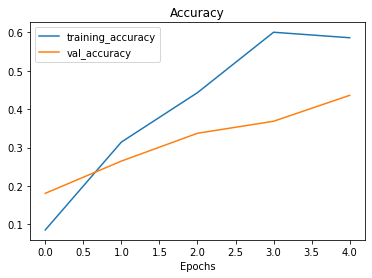

In [22]:
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% augmentation. 

In [23]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [24]:
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = (224,224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode = "categorical",
                                                                image_size = (224,224))



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [25]:
# Create a model_2

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer. 
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal")
    ,preprocessing.RandomHeight(0.2), 
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = "data_augmentation")

# Setup the input shape of the model. 
input_shape = (224, 224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Create the inputs and outputs including the layers in between. 
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False) 
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ["accuracy"])

In [26]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


# Let's create checkpoint

In [27]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                                         save_weights_only = True, 
                                                         save_best_only = False , 
                                                         save_freq = "epoch",
                                                         verbose = 1)

# Let's fit the model. 

In [28]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data, 
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback
                                                                                   ])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210922-162617
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 856ms/step - loss: 1.9948 - accuracy: 0.3507 - val_loss: 1.4767 - val_accuracy: 0.6990

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 14s 581ms/step - loss: 1.3690 - accuracy: 0.6707 - val_loss: 1.0409 - val_accuracy: 0.7730

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 14s 554ms/step - loss: 1.0563 - accuracy: 0.7560 - val_loss: 0.8800 - val_accuracy: 0.7862

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 16s 666ms/step - loss: 0.8905 - accuracy: 0.7813 - val_loss: 0.7450 - val_accuracy: 0.8092

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 530ms/step - loss: 0.7873 - accuracy: 0.8040 - val_

In [29]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6029 - accuracy: 0.8412


[0.6028948426246643, 0.8411999940872192]

In [30]:
# Results 
result_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6963 - accuracy: 0.8072


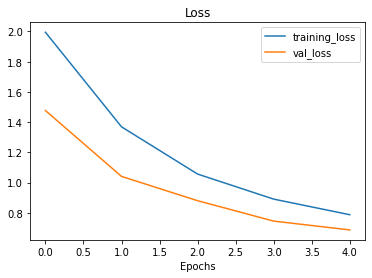

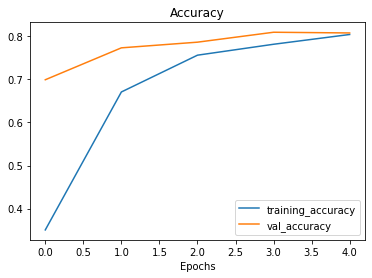

In [31]:
plot_loss_curves(history_10_percent_data_aug)

# Loading checkpointed weights. 


In [32]:
model_2.load_weights(checkpoint_path)

In [33]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6963 - accuracy: 0.8072


In [34]:
result_10_percent_data_aug == loaded_weights_model_results

True

In [35]:
import numpy as np
# np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))#

# Fine tuning an existing model on 10% data. 

In [36]:
model_2.layers

In [37]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f534d06a350> True
<keras.engine.sequential.Sequential object at 0x7f52d175e210> True
<keras.engine.functional.Functional object at 0x7f52d12c5810> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f52d13a2790> True
<keras.layers.core.Dense object at 0x7f52d12e7190> True


In [38]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [39]:
# How many variables are trainable in our base model. 
print(len(model_2.layers[2].trainable_variables))

0


In [40]:
base_model.trainable = True

# Freeze all the layers except for the last 10 
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Let's recompile the model. 
model_2.compile(loss = "categorical_crossentropy", 
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001), 
                metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
# Check which layers are tunable. (trainable)
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [42]:
print(len(model_2.trainable_variables))

12


In [43]:
# Fine tune for another 5 epochs.
fine_tune_epochs = initial_epochs + 5 

# # Fitting the model. 
# history_10_percent_data_aug = model_2.fit(train_data_10_percent, 
#                                           epochs = fine_tune_epochs, 
#                                           validation_data = test_data, 
#                                           validation_steps = int(0.25 * len(test_data)),
#                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
#                                           callbacks = create_tensorboard_callbacks(dir_name = "transfer_learning", 
#                                                                                    experiment_name = "10_percent_fine_tune_last_10"))


# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210922-162914
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 24s 669ms/step - loss: 0.6943 - accuracy: 0.8133 - val_loss: 0.5544 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 16s 629ms/step - loss: 0.5925 - accuracy: 0.8160 - val_loss: 0.5239 - val_accuracy: 0.8125
Epoch 7/10
24/24 [==============================] - 13s 548ms/step - loss: 0.4613 - accuracy: 0.8613 - val_loss: 0.5192 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 13s 510ms/step - loss: 0.4618 - accuracy: 0.8520 - val_loss: 0.4916 - val_accuracy: 0.8257
Epoch 9/10
24/24 [==============================] - 12s 488ms/step - loss: 0.4210 - accuracy: 0.8720 - val_loss: 0.4932 - val_accuracy: 0.8405
Epoch 10/10
24/24 [==============================] - 12s 504ms/step - loss: 0.3657 - accuracy: 0.8947 - val_loss: 0.5001 - val_accuracy: 0.8257


In [44]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.4940 - accuracy: 0.8252


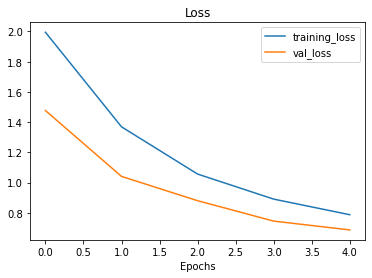

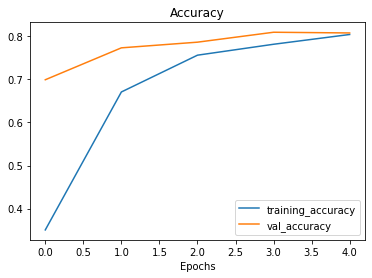

In [45]:
plot_loss_curves(history_10_percent_data_aug)

In [50]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

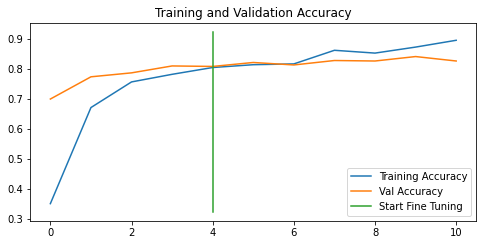

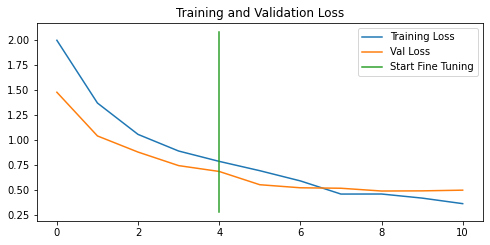

In [51]:
compare_historys(history_10_percent_data_aug, 
                 history_fine_10_percent_data_aug, 
                 initial_epochs = 5)

# Model 4: Fine tuning and existing model on all the data. 

In [52]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-09-22 16:46:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   184MB/s    in 2.7s    

2021-09-22 16:46:36 (184 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [53]:
# Setup training and testing dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [54]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [56]:

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [57]:
model_2.load_weights(checkpoint_path)

In [58]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [59]:
# Compile the model. 
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [63]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210922-164900
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 71s 264ms/step - loss: 0.7414 - accuracy: 0.7633 - val_loss: 0.4307 - val_accuracy: 0.8602
Epoch 6/10
235/235 [==============================] - 80s 338ms/step - loss: 0.6061 - accuracy: 0.8028 - val_loss: 0.3408 - val_accuracy: 0.8882
Epoch 7/10
235/235 [==============================] - 74s 313ms/step - loss: 0.5348 - accuracy: 0.8243 - val_loss: 0.3014 - val_accuracy: 0.8997
Epoch 8/10
235/235 [==============================] - 67s 283ms/step - loss: 0.4915 - accuracy: 0.8432 - val_loss: 0.3225 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 65s 275ms/step - loss: 0.4617 - accuracy: 0.8531 - val_loss: 0.3132 - val_accuracy: 0.8931
Epoch 10/10
235/235 [==============================] - 63s 266ms/step - loss: 0.4259 - accuracy: 0.8617 - val_loss: 0.3083 - val_accuracy: 0.8997


In [61]:
result_fine_tune_full_data = model_2.evaluate(test_data)
result_fine_tune_full_data

79/79 [==============================] - 14s 132ms/step - loss: 0.6963 - accuracy: 0.8072


[0.6962643265724182, 0.807200014591217]

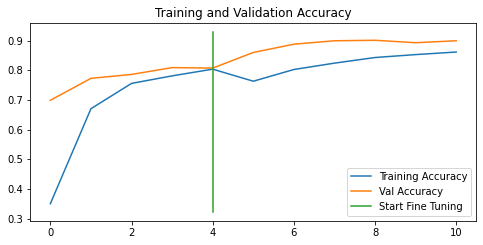

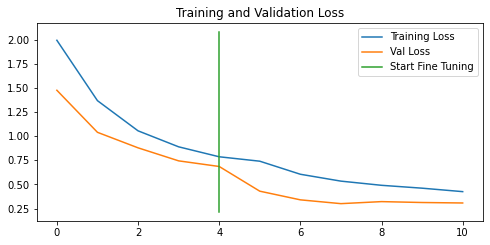

In [64]:
compare_historys(history_10_percent_data_aug ,history_fine_10_classes_full)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

2021-09-22 16:57:02.117820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 16:57:02.185312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 16:57:02.185892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Priv